In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline

## Define a Gaussian Process Class ##

In [2]:
class GPR():
    def __init__(self, kernel, alpha=1e-10, n_restarts_optimizer=1):
        self.gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, n_restarts_optimizer=5)
    def fit(self, X, Y):
            self.X=X
            self.Y=Y
            self.n_features=np.shape(self.X)[1]
            self.n_samples=np.shape(self.X)[0]
            self.gp.fit(self.X,self.Y)
            self.kernel= self.gp.kernel_
            self.kernel_params_= [self.kernel.get_params()['k1__k2__length_scale'], self.kernel.get_params()['k1']]
            self.noise_var_ = self.gp.alpha + self.kernel.get_params()['k2__noise_level']
            K_ = self.kernel(X, X) + (self.noise_var_ * np.eye(len(X)))
            self.K_inv = np.linalg.inv(K_)
            
    def predict(self,x):
        [y, std]=self.gp.predict(x, return_std=True)
        
        return np.array(y), np.array(std)
         
    def derivative(self, x): # GP with RBF kernel 
        """Input has shape n_query x n_features. 
        There are two outputs,
        1. derivative of the mean
        2. derivative of the predicted variance 
        Each utput has shape n_query x n_features x n_outputs.
        The output in position i,j,k has the derivative respect to the j-th feature of the k-th output, in position of the i-th data point.
        For the derivative of sigma n_outputs is equal to 1"""
        lscale=self.kernel_params_[0].reshape(-1,1)
        lscale_stack= np.hstack([lscale]*self.n_samples)
        alfa=  np.matmul(self.K_inv, self.Y)
        dy_dx=[]
        dsigma_dx=[]
        for i in range(np.shape(x)[0]):
            k_star= self.kernel(self.X, x[i,:].reshape(1,-1))
            k_star_T=k_star.transpose()
            k_star_stack= np.vstack([k_star_T]*self.n_features)
            beta = -2 * np.matmul(self.K_inv, k_star)
            dk_star_dX=- k_star_stack * (self.X- x[i,:]).transpose()/ (lscale_stack** 2)
            dy_dx.append(np.matmul(dk_star_dX, alfa))
            dsigma_dx.append(np.matmul(dk_star_dX, beta))
        return np.array(dy_dx), np.array(dsigma_dx)

## TOY Example ##

/home/oem/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


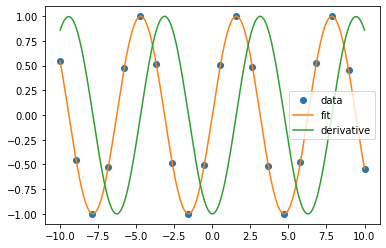

In [3]:
X=np.linspace(-10,10,20)
Y=np.sin(X)
X=X.reshape(-1,1)
Y=Y.reshape(-1,1)
plt.plot(X,Y, 'o')
k = C(constant_value=np.sqrt(0.1))  * RBF(1*np.ones(1)) + WhiteKernel(0.01 )
gp=GPR(kernel=k)
gp.fit(X,Y)
X_test=np.linspace(-10,10,1000).reshape(-1,1)
Y_pred=gp.predict(X_test)[0]
Y_der=gp.derivative(X_test)[0]
plt.plot(X_test, Y_pred)
plt.plot(X_test, Y_der[:,0,0])
plt.legend(["data","fit","derivative"])

## Fit a planar dynamical system from the LASA dataset ##

In [4]:
from load_data import _PyLasaDataSet
DataSet = _PyLasaDataSet()

angle_data = DataSet.BendedLine
demos = angle_data.demos # list of 7 Demo objects, each corresponding to a 
                         # repetition of the pattern
downsample=10
X=np.transpose(demos[0].pos[:,100::downsample]) 
X_dot=np.zeros((len(X),2))
for j in range(len(X)-1): 
    X_dot[j,:]=(X[j+1,:]-X[j,:])
ind=range(1,5)
for i in ind:
    X_traj=np.transpose(demos[i].pos[:,100::downsample])
    X=np.vstack((X, X_traj))
    X_dot_traj=np.zeros((len(X_traj),2))
    for j in range(len(X_traj)-1): 
        X_dot_traj[j,:]=np.transpose(X_traj[j+1,:]-X_traj[j,:])
    X_dot=np.vstack((X_dot, X_dot_traj))  

Using LASA DataSet from /home/oem/Desktop/UCL/ILoSA/example/DataSet


### Let's initialize and train a Gaussian Process

In [5]:
#k = C(constant_value=np.sqrt(0.1))  * RBF(1*np.ones(2)) + WhiteKernel(0.01)
k = C(constant_value=np.sqrt(0.1))  * Matern(1*np.ones(2), nu=1.5) + WhiteKernel(0.01 ) #this kernel works much better!    
gp=GPR(kernel=k)
gp.fit(X, X_dot)

### Let's define a grid where to evaluate the learned dynamical system 

In [6]:
x_grid=np.linspace(np.min(X[:,0]-10), np.max(X[:,0]+10), 100)
y_grid=np.linspace(np.min(X[:,1]-10), np.max(X[:,1]+10), 100)
# Creating grids
XX, YY = np.meshgrid(x_grid, y_grid)
u=np.ones((len(x_grid),len(y_grid)))
v=np.ones((len(x_grid),len(y_grid)))

### Let's plot the prediction with a vanilla Matern GP <ins>without</ins> stabilization vector

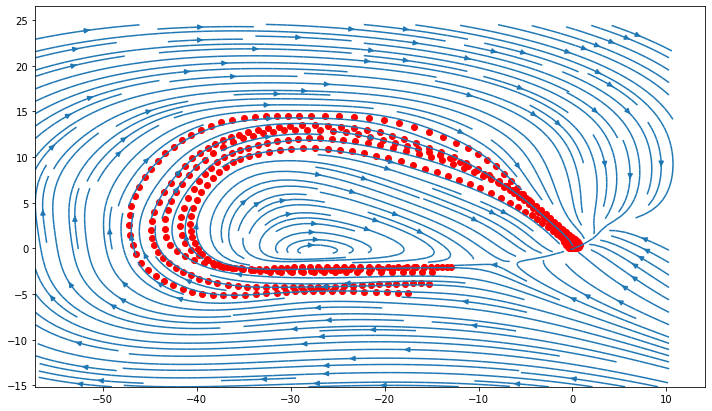

In [7]:
for i in range(len(x_grid)):
    for j in range(len(y_grid)):
        pos=np.array([XX[i,j],YY[i, j]]).reshape(1,-1)
        [vel, var]=gp.predict(pos)
        u[i,j]=vel[0][0]
        v[i,j]=vel[0][1]
fig = plt.figure(figsize = (12, 7))
plt.streamplot(XX, YY, u, v, density = 2)
plt.scatter(X[:,0],X[:,1], color=[1,0,0])
plt.show() 

### Let's plot the prediction with a vanilla Matern GP <ins>with</ins> stabilization field.
Please notice that we are only getting the direction for the stabilization but the magnitude is set a 2 times the standard deviation of the GP. This is slighly different from the paper but it ensures that the effect of the gradint does not vanish. 

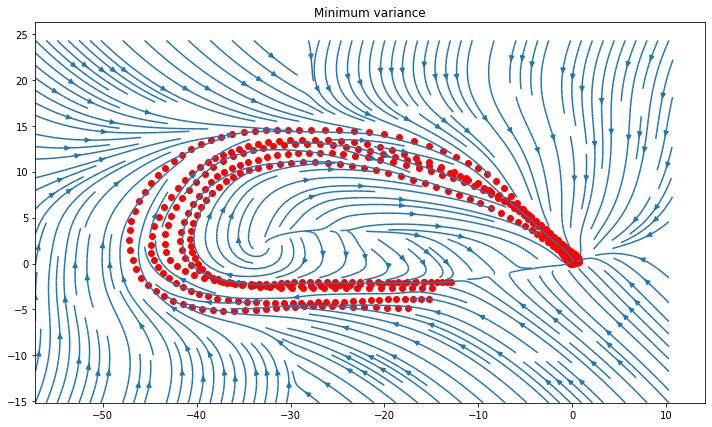

In [8]:
for i in range(len(x_grid)):
    for j in range(len(y_grid)):
        pos=np.array([XX[i,j],YY[i, j]]).reshape(1,-1)
        [vel, std]=gp.predict(pos)
        [_,grad]=gp.derivative(pos)
        u[i,j]=vel[0,0]+2*std[0]*grad[0,0,0]/np.sqrt(grad[0,0,0]**2+grad[0,0,0]**2)
        v[i,j]=vel[0,1]+2*std[0]*grad[0,1,0]/np.sqrt(grad[0,0,0]**2+grad[0,1,0]**2)

fig = plt.figure(figsize = (12, 7))

plt.streamplot(XX, YY, u, v, density = 2)
plt.scatter(X[:,0],X[:,1], color=[1,0,0]) 
plt.title("Minimum variance")
plt.show()

# Which is your fovourite? 
Let me know at g.franzese@tudelft.nl